In [56]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.config_builder import get_config



from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC
al_output  data		      log     pipeline_configs	requirements.txt  src
archive    jupyter_notebooks  output  README.md		shell_scripts	  wandb


In [2]:
def show_image_by_id(image_id, ds_json):
    image_json = tuple(filter(lambda x: x["image_id"] == image_id,  ds_json))[0]
    raw_im = cv2.imread(image_json["file_name"])
    show_image([raw_im])

In [3]:
register_datasets()
ds_json = DatasetCatalog.get(get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
))

registering acdc_small dataset
registering acdc_large dataset



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [4]:
running_on_server = False
print("running on server:", running_on_server)
cfg = get_config("acdc_large_al")

mc_trainer = ActiveLearningTrainer(cfg, is_test_mode=not running_on_server)
rd_trainer = ActiveLearningTrainer(cfg, is_test_mode=not running_on_server)


#al_trainer.run(dataset=ACDC_LARGE, query_strat=MC_DROPOUT)
#al_trainer.run(dataset=ACDC_LARGE, query_strat=RANDOM)
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

mc_trainer.cfg.AL.DATASETS.TRAIN_UNLABELED = get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
)
#rd_trainer.cfg.AL.DATASETS.TRAIN_UNLABELED = get_dataset_name(
#    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
#)
mc_trainer.al_dataset = ActiveLearingDataset(mc_trainer.cfg)
#rd_trainer.al_dataset = ActiveLearingDataset(rd_trainer.cfg)

mc_trainer.query_strategy = MCDropoutSampler(mc_trainer.cfg)
#rd_trainer.query_strategy = RandomSampler(rd_trainer.cfg)


running on server: False
registering acdc_small dataset
registering acdc_large dataset
[01/19 10:56:53 d2.data.datasets.coco]: Loading ./data/acdc_large/train/cell_acdc_coco_ds.json takes 4.49 seconds.
WARNING [01/19 10:56:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/19 10:56:53 d2.data.datasets.coco]: Loaded 5499 images in COCO format from ./data/acdc_large/train/cell_acdc_coco_ds.json
update_labeled_data


['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_224', 'acdc_data3_Yagya_SCD_WT_pos_6_34', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_130', 'acdc_data2_beer_experiment1_pos_44_81', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_102']


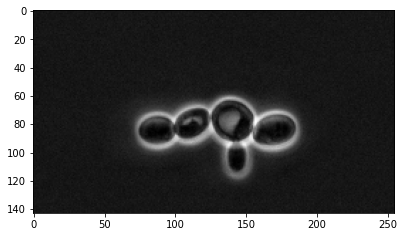

In [5]:
print(mc_trainer.al_dataset.labeled_ids)
show_image_by_id(mc_trainer.al_dataset.labeled_ids[2], ds_json)


In [6]:
i = 0

In [15]:
mc_trainer.step(resume=(i>0))
i += 1
print(mc_trainer.al_dataset.labeled_ids)

WARNING [01/19 11:12:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [01/19 11:15:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.65s).
Accumulating evaluation results...
DONE (t=0.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.851
 Average Recall     (AR) @[ IoU

100%|██████████| 5494/5494 [1:14:45<00:00,  1.22it/s]


finished with mc dropout sampling.
min uncertainty:  0.2701762318611145 	 mean uncertainty:  0.6634631311411766 	 max uncertainty:  0.877453088760376
worst examples: ['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_34', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_labeled_pos_1_0', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_38', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_3_11', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0']
update_labeled_data
['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_224', 'acdc_data3_Yagya_SCD_WT_pos_6_34', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_130', 'acdc_data2_beer_experiment1_pos_44_81', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_102', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_34', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_labeled_pos_1_0', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_38', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_3_11', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0']


In [106]:
def outputs_to_mean_img(outputs):
    masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
    image_shape= masks[0][0].shape
    images = []
    for mask in masks:
        image = np.zeros(image_shape)

        for id in range(len(mask)):
            np.place(image, mask[id], 1)
        images.append(image)

    images = np.array(images)
    return images.mean(axis=0)


def outputs_to_uncertainty_map(outputs):
    masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
    image_shape= masks[0][0].shape
    images = []
    for mask in masks:
        image = np.zeros(image_shape)

        for id in range(len(mask)):
            np.place(image, mask[id], 1)
        images.append(image)

    images = np.array(images)
    return 0.5 - np.abs(images.mean(axis=0) -0.5)

In [17]:
def show_uncertainty(image_id):
    image_json = tuple(filter(lambda x: x["image_id"] == image_id,  ds_json))[0]
    im = cv2.imread(image_json["file_name"])

    model = build_model(cfg)
    model = patch_module(model)
    model.eval()

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(os.path.join(cfg.OUTPUT_DIR, "best_model.pth"))
    outputs = mc_trainer.query_strategy.get_mc_dropout_samples(cfg, model, im, 10)
    show_image([im,outputs_to_mean_img(outputs)])





TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_224


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


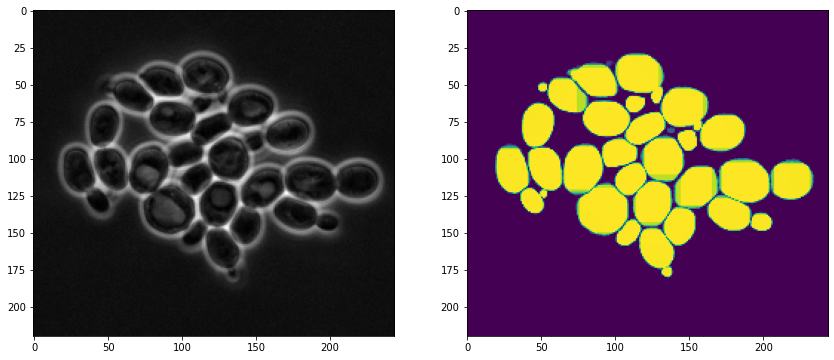

acdc_data3_Yagya_SCD_WT_pos_6_34


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


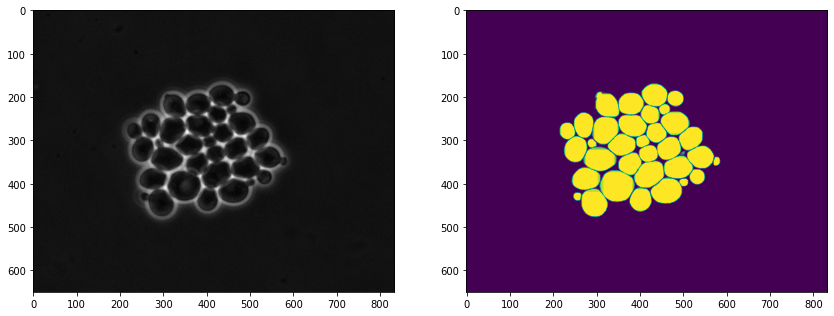

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_130


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


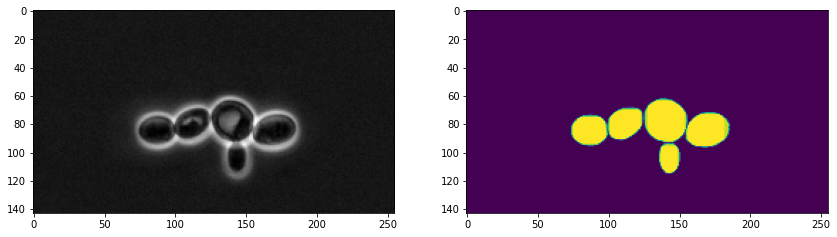

acdc_data2_beer_experiment1_pos_44_81


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


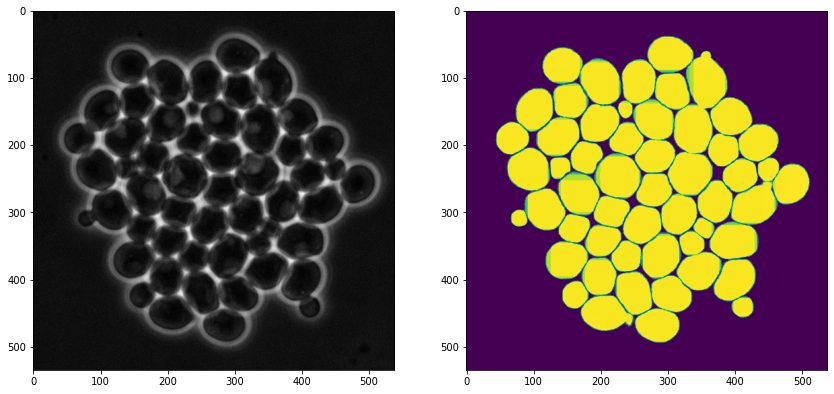

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_102


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


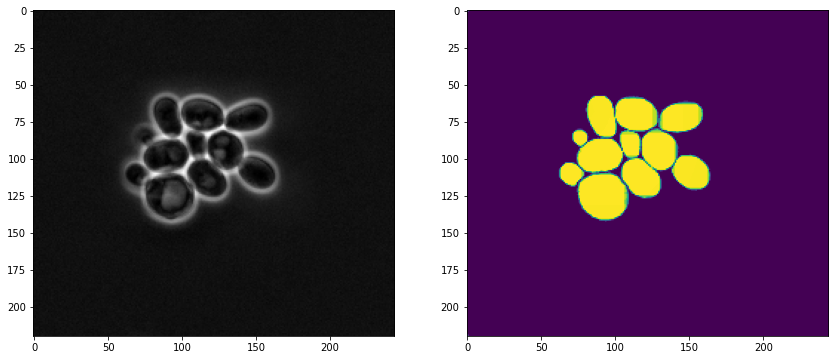

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_34


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


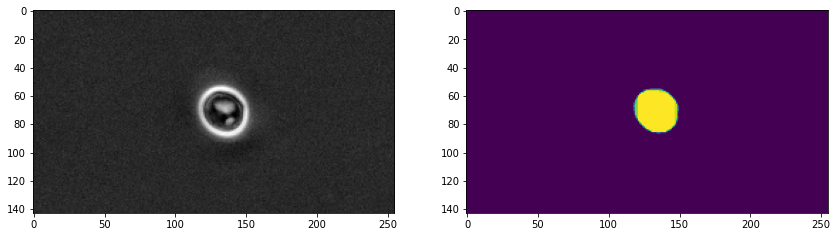

TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_labeled_pos_1_0


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


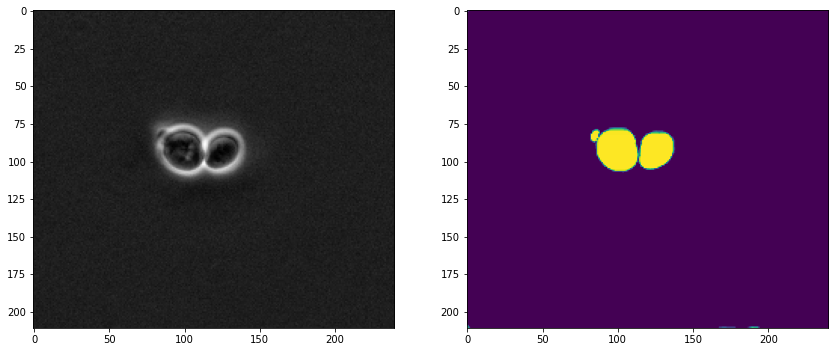

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_2_38


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


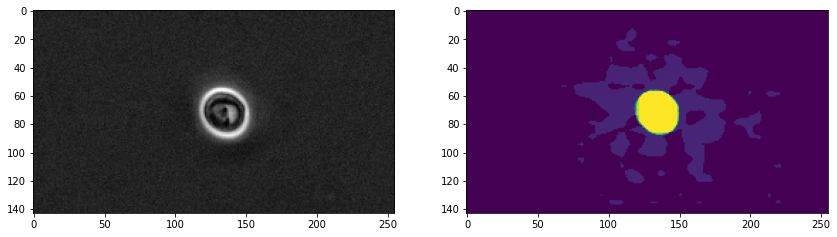

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_3_11


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


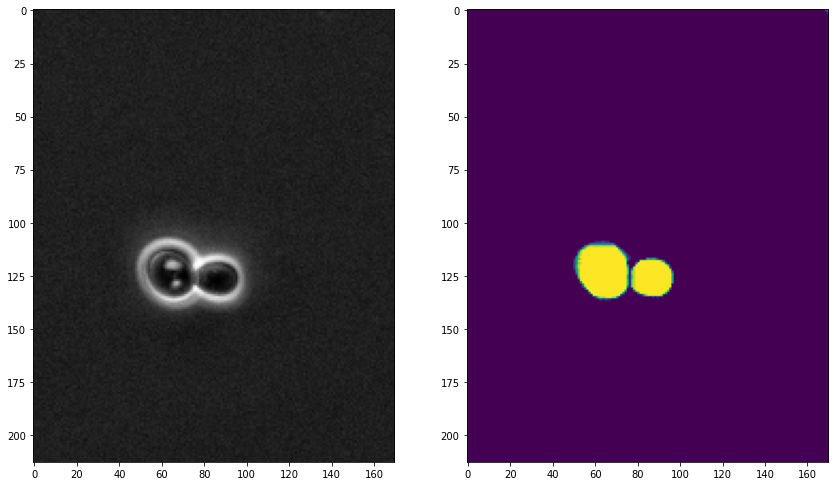

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0


/tmp/ipykernel_48566/4265722078.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


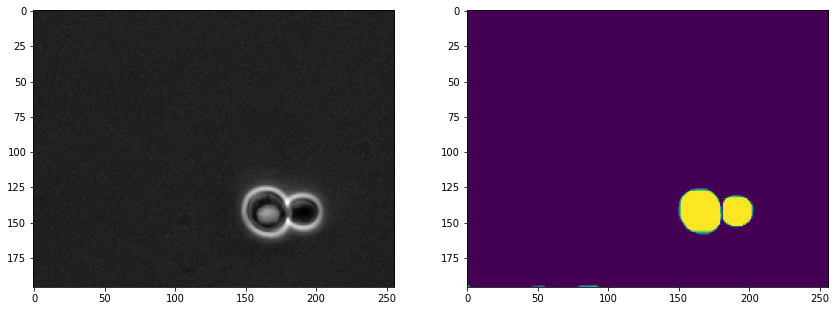

In [18]:
for image_id in mc_trainer.al_dataset.labeled_ids:
    print(image_id)
    show_uncertainty(image_id)
    

In [20]:
def get_image_ids_by_exp(exp, image_ids):
    return list(filter(lambda x: x.find(exp) != -1, image_ids))

In [160]:
cfg_tmp = mc_trainer.cfg
cfg_tmp.OUTPUT_DIR = "/home/florian/GitRepos/activeCell-ACDC/archive/tmp"
cfg_tmp.MODEL.ROI_BOX_HEAD.DROPOUT_PROBABILITY = 0.3
cfg_tmp.MODEL.ROI_MASK_HEAD.DROPOUT_PROBABILITY = 0.3

position = "TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4"

mc_d = MCDropoutSampler(cfg_tmp)
mc_d.sample(cfg=cfg_tmp, ids=get_image_ids_by_exp(position, [image["image_id"] for image in ds_json]))

WARNING [01/19 15:23:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

running mc dropout sampling...


100%|██████████| 240/240 [01:32<00:00,  2.59it/s]

finished with mc dropout sampling.
min uncertainty:  0.5558425784111023 	 mean uncertainty:  0.8102529341975848 	 max uncertainty:  0.9072960615158081
worst examples: ['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_27', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_71', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_62', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_38']


['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_27',
 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_71',
 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72',
 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_62',
 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_38']

In [163]:
with open("/home/florian/GitRepos/activeCell-ACDC/al_output/acdc_large_al/mc_dropout/uncertainties1.json", "r") as file:
    exp_unc = json.load(file)

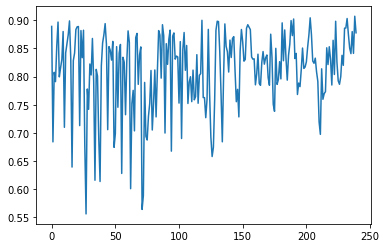

In [164]:
res = []
for image in exp_unc.keys():
    #print(int(image.split("_")[-1]), exp_unc[image])
    res.append((int(image.split("_")[-1]), exp_unc[image]))

#sorted(res)
import matplotlib.pyplot as plt
plt.plot(*zip(*sorted(res)))

In [149]:
def show_uncertainty_new(image_id, cfg):
    image_json = tuple(filter(lambda x: x["image_id"] == image_id,  ds_json))[0]
    im = cv2.imread(image_json["file_name"])

    model = build_model(cfg)
    model = patch_module(model)
    model.eval()

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(os.path.join(cfg.OUTPUT_DIR, "best_model.pth"))
    outputs = mc_d.get_mc_dropout_samples(cfg, model, im, 10)
    predictions = mc_d.get_observations(outputs)
    height, width = im.shape[:2]
    uncertainty = mc_d.get_uncertainty(predictions, 10, height, width)
    show_image([im,outputs_to_mean_img(outputs), outputs_to_uncertainty_map(outputs)], normalize=False)
    print("uncertainy", str(uncertainty), "self unc: ", outputs_to_uncertainty_map(outputs).sum()/(outputs_to_mean_img(outputs) == 1).sum())
    return outputs

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72 68


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


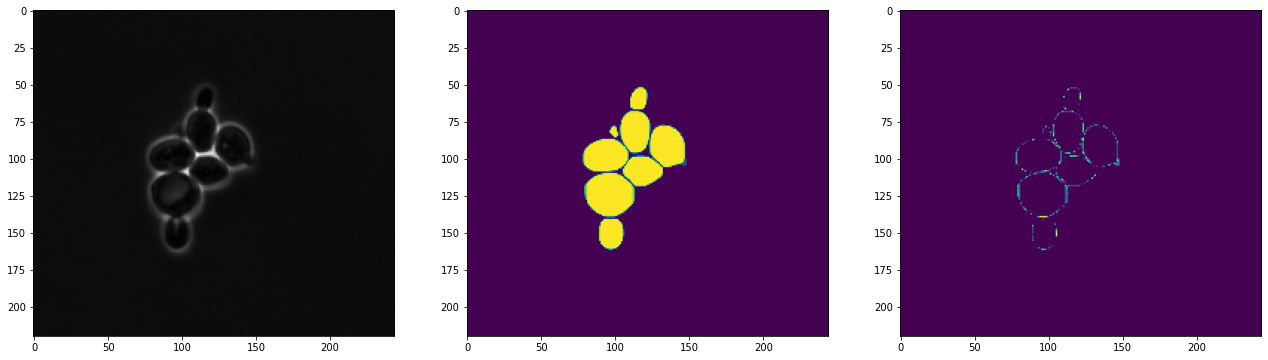

uncertainy 0.028987085 self unc:  0.025850567044696463


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


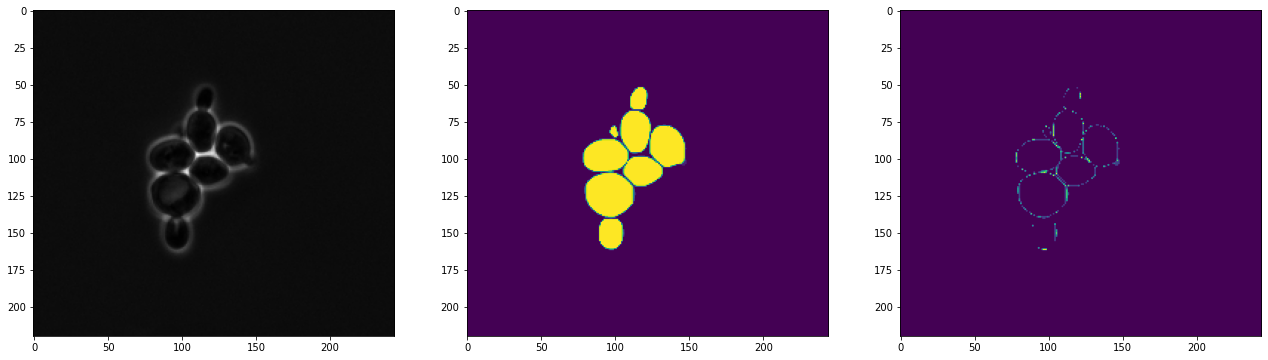

uncertainy 0.058671147 self unc:  0.023505843071786308
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72 71


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


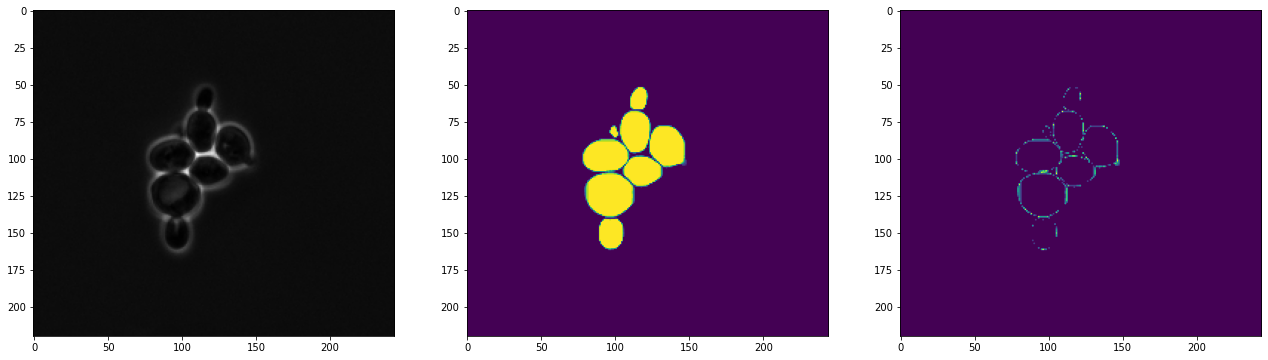

uncertainy 0.009365902 self unc:  0.029559322033898307


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


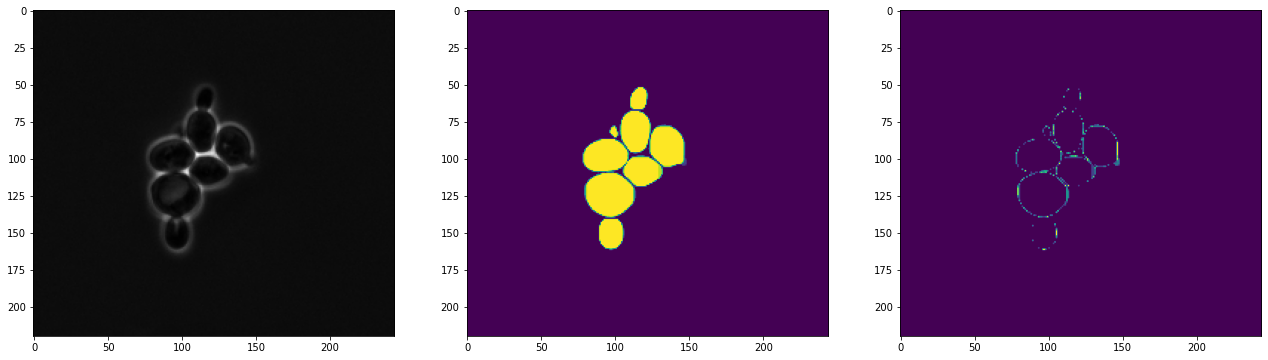

uncertainy 0.039693445 self unc:  0.027616181878970247
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72 72


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


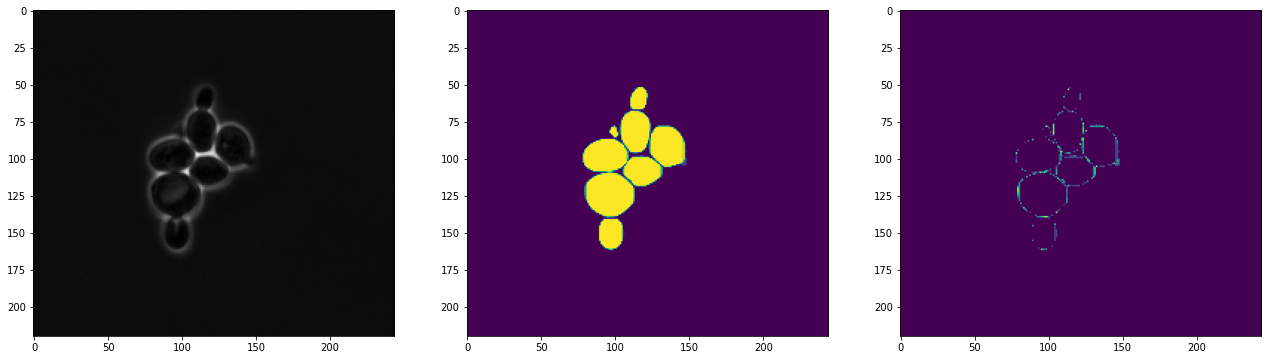

uncertainy 0.024511805 self unc:  0.02683008730691739


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


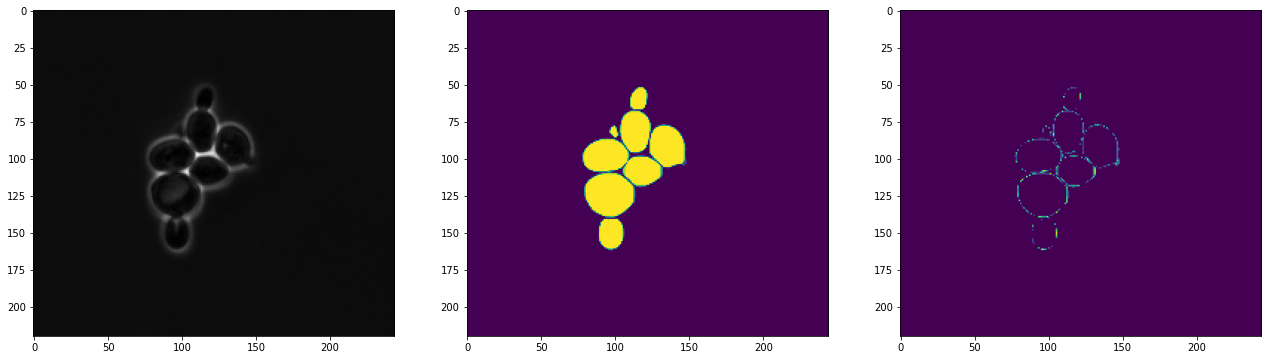

uncertainy 0.027329639 self unc:  0.02711807871914609
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72 73


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


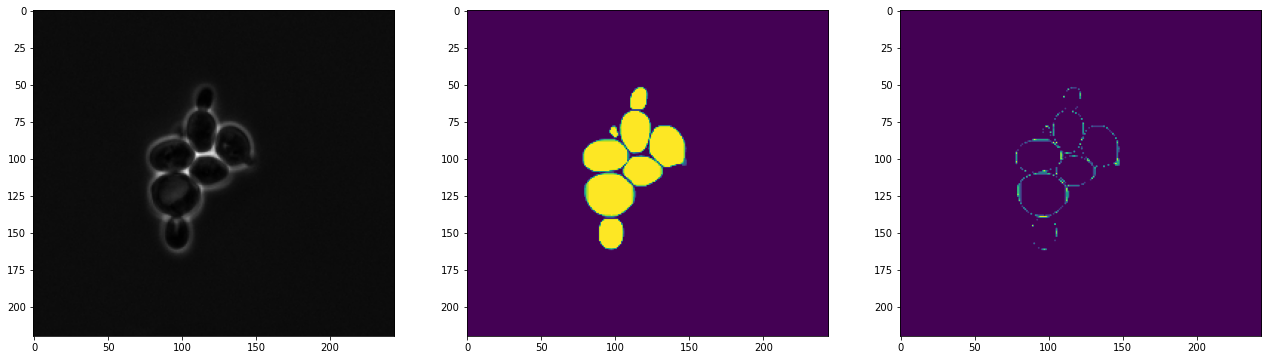

uncertainy 0.14689907 self unc:  0.030951574669827297


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


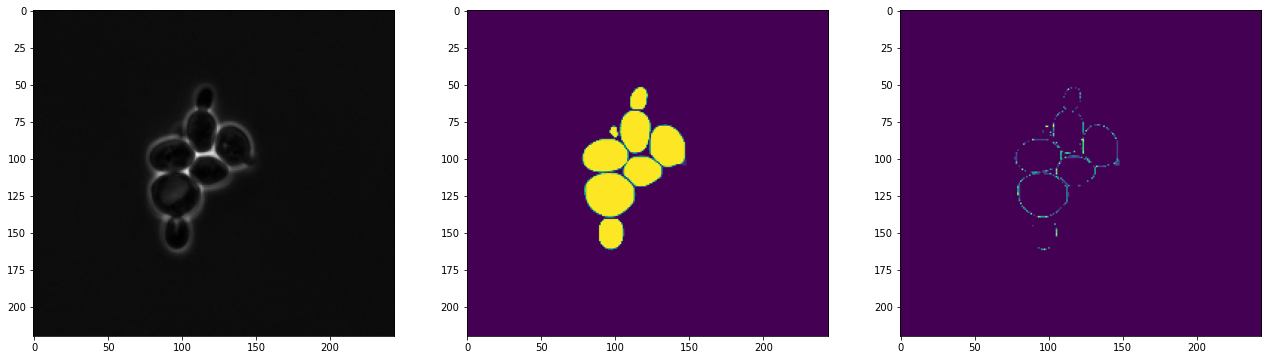

uncertainy 0.059546065 self unc:  0.02560691719321583
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_72 74


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


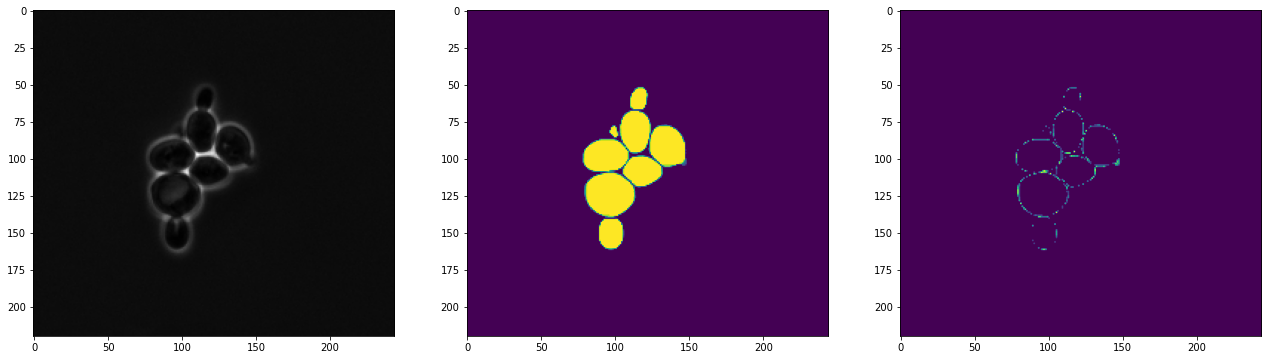

uncertainy 0.035403203 self unc:  0.025347452018530774


/tmp/ipykernel_48566/2213125156.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2213125156.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


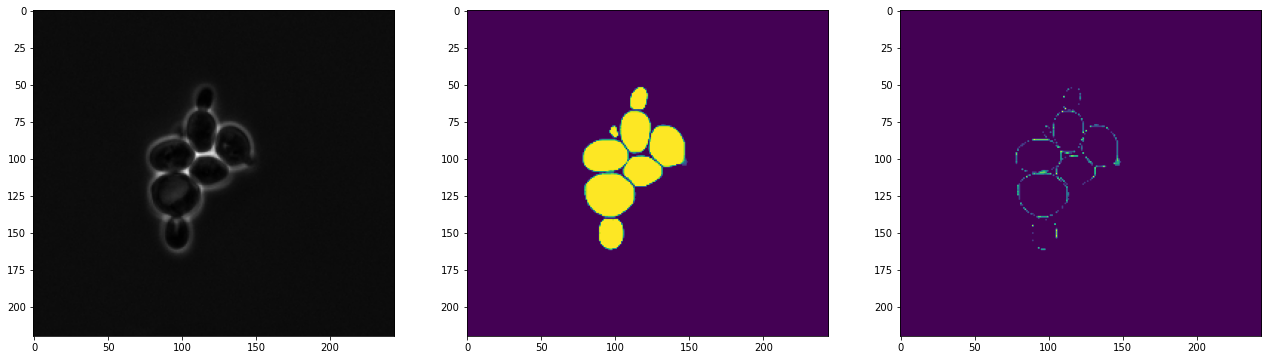

uncertainy 0.019964058 self unc:  0.027639027639027633


In [159]:
for img in [68,71, 72,73,74]:
    image_id = f"TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_{72}"
    #image_id = "TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_38"
    #image_id = "TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_203"
    print(image_id,img)
    show_uncertainty_new(image_id, cfg_tmp)
    show_uncertainty_new(image_id, cfg_tmp)
    

/tmp/ipykernel_48566/2496558367.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
/tmp/ipykernel_48566/2496558367.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])


14.07778930980799


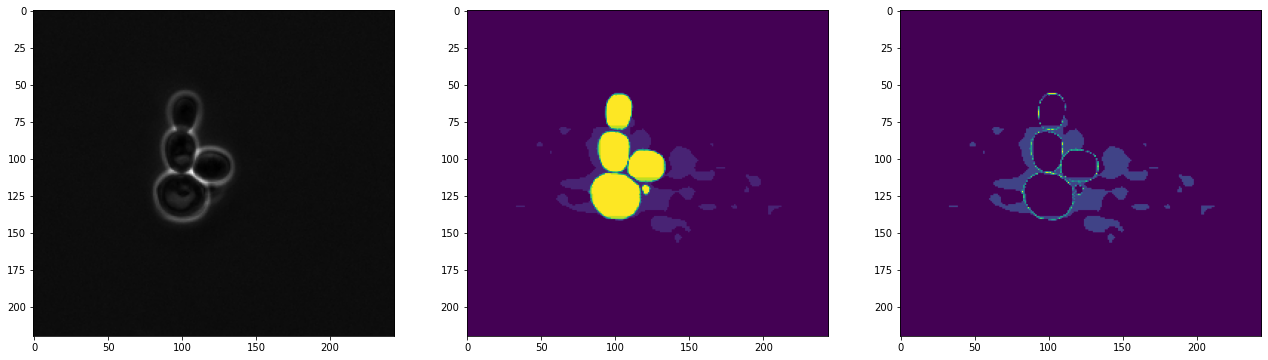

uncertainy 0.2927141


In [67]:
outputs = show_uncertainty_new(image_id, cfg_tmp)

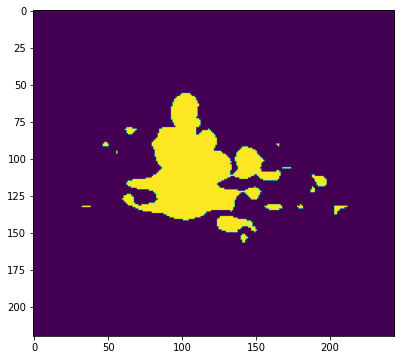

In [85]:
i = 8
show_image([outputs_to_mean_img(outputs[i:i+ 1])])

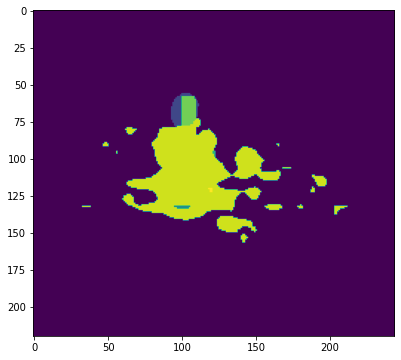

In [97]:
mask = np.array(outputs[8]["instances"].pred_masks.to("cpu"))
image_shape= mask[0].shape
image = np.zeros(image_shape)

for id in range(len(mask)):
    np.place(image, mask[id], id)
show_image([image], normalize=False)
